## Imports

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  

from sklearn import svm, linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

sys.path.insert(0, '../../../Utils/')

import models
from train import *
from metrics import * 
from SVC_Utils import *

#audio
import librosa as libr

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Python: 3.6.5 (default, Jul  6 2018, 19:12:46) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## NN Hyperparameters

In [2]:
batch_size = 128
lr = 0.001
k = 3

transform_type = 'SFTF' #either STFT or MFCC  

if transform_type == 'SFTF':
    target_net_type = models.STFT_CNN_classifier
    shadow_net_type = models.STFT_CNN_classifier
    in_size = 94# 20 forMFCC,  94 for STFT
elif transform_type == 'MFCC':
    target_net_type = models.audio_CNN_classifier
    shadow_net_type = models.audio_CNN_classifier
    in_size = 20

## Load LibriSpeech data:

In [3]:
### Hyperparameters

n_seconds = 3
n_epochs = 25
sampling_rate = 16000
number_of_mels =128
data_set = 100 #100 or 360
if data_set == 100:
    all_data = ['train-clean-100']
elif data_set == 360:
    all_data = ['train-clean-360']
lr = 0.001

### Speech preprocessing

class tensorToMFCC:
    def __call__(self, y):
#         y = y.numpy()
        dims = y.shape
        y = libr.feature.melspectrogram(np.reshape(y, (dims[1],)), 16000, n_mels=number_of_mels,
                               fmax=8000)
        y = libr.feature.mfcc(S = libr.power_to_db(y))
        y = torch.from_numpy(y)                           
        return y.float()


class STFT:
    def __call__(self,y):
        dims = y.shape
        y = np.abs(libr.core.stft(np.reshape(y, (dims[1],))))
        y = torch.from_numpy(y).permute(1,0)
        return y.float()

if transform_type == 'SFTF':
    transform  = STFT() ## STFT or MFCC
elif transform_type == 'MFCC':
    transform  = tensorToMFCC()
    
### Data set

%load_ext autoreload
%autoreload 2
sys.path.insert(0, './../../../Utils')
from datasets import LibriSpeechDataset
from datasets import Libri_preload_and_split

path = './../../../Classification_baselines/LibriSpeech/data/'

splits = [0.8, 0.2] #input fraction of data you want partitioned. Train, test fraction
attacking = 1 #0 for no attack, 1 for attack 1, 3 for attack 3
# attacking means data for a target & shadow network.
# This will also split "out data" from totally different speakers -- data none of the 
# other networks have seen, for training & testing the attack network. This will be
# an equivalent amount of data to the train split as defined about

if sum(splits) != 1:
    print('error: splits do not sum to 1.')

#Splits data into 2 sets of speakers for target & shadow network, into above defined train:test splits
dfs = Libri_preload_and_split(path,all_data,n_seconds,pad=False,cache=True,splits=splits, attacking = attacking)  

#target train & test
valid_sequence_train = LibriSpeechDataset(path, df = dfs[0], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

valid_sequence_test = LibriSpeechDataset(path, df = dfs[1], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

#shadow train & test
valid_sequence_train_shadow = LibriSpeechDataset(path, df = dfs[2], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)



valid_sequence_test_shadow = LibriSpeechDataset(path, df = dfs[3], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)


valid_sequence_out = LibriSpeechDataset(path, df = dfs[4], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

valid_sequence_out_shadow = LibriSpeechDataset(path, df = dfs[5], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['train-clean-100']
Finished indexing data. 27949 usable files found.
6039
1544
6279
1603
6210
6274
Finished splitting data.


In [4]:
batch_size = 32

# Loaders for data for target model & shadow model 
target_train_loader = DataLoader(valid_sequence_train,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8,
                    drop_last = True
                     # pin_memory=True # CUDA only
                     )

target_out_loader = DataLoader(valid_sequence_out,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8,
                    drop_last = True
                     # pin_memory=True # CUDA only
                     )

target_test_loader = DataLoader(valid_sequence_test,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )

shadow_train_loader = DataLoader(valid_sequence_train_shadow,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8,
                    drop_last = True
                     # pin_memory=True # CUDA only
                     )

shadow_out_loader = DataLoader(valid_sequence_out_shadow,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8,
                    drop_last = True
                     # pin_memory=True # CUDA only
                     )

shadow_test_loader = DataLoader(valid_sequence_test_shadow,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )


# Initialize/Train Targets
The model being attacked; if network, architecture can differ from that of shadow network.

In [5]:
#Initialize NN

#in_size defined above
n_hidden = 512
n_classes = valid_sequence_test.num_speakers
print(n_classes)

target_net = target_net_type(in_size,n_hidden,n_classes).to(device)
target_net.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)

69


In [6]:
#Train NN

train(target_net, target_train_loader, target_test_loader, target_optim, target_loss, n_epochs, verbose = False) #classes = range(valid_sequence_test.num_speakers),

[0/25]
Training:

Accuracy = 73.92 %


Test:

Accuracy = 62.24 %


[1/25]
Training:

Accuracy = 92.62 %


Test:

Accuracy = 80.83 %


[2/25]
Training:

Accuracy = 94.00 %


Test:

Accuracy = 81.41 %


[3/25]
Training:

Accuracy = 95.86 %


Test:

Accuracy = 83.68 %


[4/25]
Training:

Accuracy = 98.25 %


Test:

Accuracy = 87.11 %


[5/25]
Training:

Accuracy = 98.89 %


Test:

Accuracy = 89.51 %


[6/25]
Training:

Accuracy = 97.91 %


Test:

Accuracy = 87.31 %


[7/25]
Training:

Accuracy = 98.99 %


Test:

Accuracy = 88.99 %


[8/25]
Training:

Accuracy = 96.56 %


Test:

Accuracy = 83.74 %


[9/25]
Training:

Accuracy = 97.91 %


Test:

Accuracy = 85.75 %


[10/25]
Training:

Accuracy = 99.53 %


Test:

Accuracy = 89.64 %


[11/25]
Training:

Accuracy = 98.15 %


Test:

Accuracy = 87.56 %


[12/25]
Training:

Accuracy = 99.65 %


Test:

Accuracy = 89.38 %


[13/25]
Training:

Accuracy = 98.84 %


Test:

Accuracy = 88.92 %


[14/25]
Training:

Accuracy = 99.34 %


Test:

Accuracy = 

In [7]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
        
epoch = 24

In [8]:
save_checkpoint({
            'epoch': epoch,
            'arch': 'audio_CNN_classifier',
            'state_dict': target_net.state_dict(),
            'optimizer' : target_optim.state_dict(),
        }, False, filename = 'model_weights/CNN_voice_classifier'+str(data_set)+'_target_'+transform_type+str(epoch)+'.pth')

In [9]:
# chpt = torch.load('model_weights/CNN_voice_classifier100_target_'+str(epoch)+'.pth')
# target_net.load_state_dict(chpt['state_dict'])

### Hold off on adapting SVM for now

In [10]:
# #Initialize SVM

# # #The stored baseline SVM was fit using all of CIFAR10 training data. To attack for membership inference, use 
# # #images not in CIFAR10 training data, or fit new classifiers/run source code with subset of CIFAR10.

# # '''
# # dir='../../../Classification_baselines/CIFAR10'
# # target_gen=load_svm(dir, gen=True)
# # target_maxacc=load_svm(dir, gen=False)
# # '''

# # #Training example targets on loaded CIFAR10 target subset:

# gen_svm=make_pipeline(PCA(n_components=180), MinMaxScaler(feature_range=(-1,1)), svm.SVC(C=10, gamma=.1, probability=True))
# maxacc_svm=make_pipeline(PCA(n_components=180), MinMaxScaler(feature_range=(-1,1)), svm.SVC(C=1, gamma=.01, probability=True))

# # sv_target_fit_loader = torch.utils.data.DataLoader(sv_cifar10_trainset, batch_size=target_train_sampler.__len__(), 
# #                                                    sampler=target_train_sampler, num_workers=1)


# tin, tout=load(target_train_loader)

# #Train SVM
# gen_svm.fit(tin, tout)
# maxacc_svm.fit(tin, tout)

In [11]:
# #evaluate SVM targets

# classes = range(n_classes)
# inp, outp=load(target_test_loader)

# print('SVM A (C=', gen_svm.get_params(deep=True)['svc__C'], ', gamma= ',
#       gen_svm.get_params(deep=True)['svc__gamma'], '): ')
# class_acc(gen_svm.predict_proba(inp), outp, classes)

# print('SVM B (C=', maxacc_svm.get_params(deep=True)['svc__C'], ', gamma= ',
#       maxacc_svm.get_params(deep=True)['svc__gamma'], '): ')
# class_acc(maxacc_svm.predict_proba(inp), outp, classes)

# Initialize/Train Shadow Model
Shadow model mimics the target network, emulating the target model's differences in prediction probabilities for samples in and out of its dataset. For this attack, only one shadow model is used. 

In [12]:
#Initialize models

n_classes = valid_sequence_test_shadow.num_speakers
print(n_classes)

#NN
shadow_net = shadow_net_type(in_size,n_hidden,n_classes).to(device)
shadow_net.apply(models.weights_init)

shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=lr)

#SVM
# shadowinputs, shadowtargets=load(sv_shadow_train_loader)
# shadow_svm=make_pipeline(PCA(n_components=180), MinMaxScaler(feature_range=(-1,1)), 
#                          svm.SVC(C=1, gamma=.1, probability=True))

69


In [13]:
# print(np.shape(shadowinputs))
# shadowtargets[5]

In [14]:
#Train NN

# below commented code is for comparison during debugging
# target_net = target_net_type(in_size,n_hidden,n_classes).to(device)
# target_net.apply(models.weights_init)

# target_loss = nn.CrossEntropyLoss()
# target_optim = optim.Adam(target_net.parameters(), lr=lr)

# train(target_net, target_train_loader, target_test_loader, target_optim, target_loss, n_epochs, verbose = False) #classes = range(valid_sequence_test.num_speakers),


train(shadow_net, shadow_train_loader, shadow_test_loader, shadow_optim, shadow_loss, n_epochs, verbose = False)

[0/25]
Training:

Accuracy = 69.10 %


Test:

Accuracy = 57.14 %


[1/25]
Training:

Accuracy = 86.38 %


Test:

Accuracy = 74.49 %


[2/25]
Training:

Accuracy = 92.25 %


Test:

Accuracy = 78.67 %


[3/25]
Training:

Accuracy = 97.96 %


Test:

Accuracy = 87.46 %


[4/25]
Training:

Accuracy = 96.67 %


Test:

Accuracy = 85.40 %


[5/25]
Training:

Accuracy = 98.84 %


Test:

Accuracy = 89.52 %


[6/25]
Training:

Accuracy = 97.86 %


Test:

Accuracy = 87.21 %


[7/25]
Training:

Accuracy = 99.04 %


Test:

Accuracy = 91.58 %


[8/25]
Training:

Accuracy = 98.76 %


Test:

Accuracy = 90.64 %


[9/25]
Training:

Accuracy = 99.36 %


Test:

Accuracy = 91.45 %


[10/25]
Training:

Accuracy = 99.87 %


Test:

Accuracy = 92.39 %


[11/25]
Training:

Accuracy = 98.37 %


Test:

Accuracy = 89.46 %


[12/25]
Training:

Accuracy = 96.40 %


Test:

Accuracy = 84.78 %


[13/25]
Training:

Accuracy = 98.26 %


Test:

Accuracy = 89.64 %


[14/25]
Training:

Accuracy = 98.93 %


Test:

Accuracy = 

In [15]:
epoch = 24
save_checkpoint({
            'epoch': epoch,
            'arch': 'CNN_voice_classifier',
            'state_dict': shadow_net.state_dict(),
            'optimizer' : shadow_optim.state_dict(),
        }, False, filename = 'model_weights/CNN_voice_classifier'+str(data_set)+'_shadow_'+transform_type+str(epoch)+'.pth')

In [16]:
#Train SVM
# shadow_svm.fit(shadowinputs, shadowtargets)

# Initialize Attack Model
A binary classifier to determine membership. 

In [17]:
#Creates two attack nets for comparison.

# attack_net_svm = models.mlleaks_mlp(n_in=k).to(device)
# attack_net_svm.apply(models.weights_init)

attack_net_nn = models.mlleaks_mlp(n_in=k).to(device)
attack_net_nn.apply(models.weights_init)

attack_loss = nn.BCEWithLogitsLoss() #this one works
# attack_loss = nn.BCELoss() # this one doesn't work 
# attack_optim_svm= optim.Adam(attack_net_svm.parameters(), lr=lr)
attack_optim_nn= optim.Adam(attack_net_nn.parameters(), lr=lr)

In [18]:
#Trains SVM attack model
# train_attacker(attack_net_svm, shadow_svm, shadow_train_loader, shadow_out_loader, attack_optim_svm, attack_loss, n_epochs=2, k=k)

In [19]:
#Trains NN attack model
attack_loss = nn.BCEWithLogitsLoss()
train_attacker(attack_net_nn, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim_nn, 
               attack_loss, n_epochs=50, k=k)

#original:
# train_attacker(attack_net_nn, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim_nn, attack_loss, n_epochs=50, k=k)

[0/50][0/196] loss = 0.81, accuracy = 50.00
[0/50][1/196] loss = 0.80, accuracy = 50.00
[0/50][2/196] loss = 0.79, accuracy = 50.00
[0/50][3/196] loss = 0.79, accuracy = 50.00
[0/50][4/196] loss = 0.78, accuracy = 50.00
[0/50][5/196] loss = 0.77, accuracy = 50.00
[0/50][6/196] loss = 0.77, accuracy = 50.00
[0/50][7/196] loss = 0.76, accuracy = 50.00
[0/50][8/196] loss = 0.75, accuracy = 50.00
[0/50][9/196] loss = 0.75, accuracy = 50.00
[0/50][10/196] loss = 0.74, accuracy = 50.00
[0/50][11/196] loss = 0.74, accuracy = 50.00
[0/50][12/196] loss = 0.73, accuracy = 50.00
[0/50][13/196] loss = 0.73, accuracy = 50.00
[0/50][14/196] loss = 0.72, accuracy = 50.00
[0/50][15/196] loss = 0.72, accuracy = 50.00
[0/50][16/196] loss = 0.71, accuracy = 50.00
[0/50][17/196] loss = 0.71, accuracy = 50.00
[0/50][18/196] loss = 0.71, accuracy = 50.00
[0/50][19/196] loss = 0.71, accuracy = 50.00
[0/50][20/196] loss = 0.70, accuracy = 50.00
[0/50][21/196] loss = 0.70, accuracy = 50.00
[0/50][22/196] loss 

[0/50][182/196] loss = 0.67, accuracy = 65.12
[0/50][183/196] loss = 0.67, accuracy = 65.17
[0/50][184/196] loss = 0.67, accuracy = 65.26
[0/50][185/196] loss = 0.66, accuracy = 65.34
[0/50][186/196] loss = 0.66, accuracy = 65.40
[0/50][187/196] loss = 0.66, accuracy = 65.46
[0/50][188/196] loss = 0.66, accuracy = 65.53
[0/50][189/196] loss = 0.67, accuracy = 65.58
[0/50][190/196] loss = 0.67, accuracy = 65.62
[0/50][191/196] loss = 0.67, accuracy = 65.65
[0/50][192/196] loss = 0.66, accuracy = 65.69
[0/50][193/196] loss = 0.66, accuracy = 65.74
[0/50][194/196] loss = 0.66, accuracy = 65.79
[0/50][195/196] loss = 0.67, accuracy = 65.82
[1/50][0/196] loss = 0.66, accuracy = 75.00
[1/50][1/196] loss = 0.65, accuracy = 79.69
[1/50][2/196] loss = 0.66, accuracy = 79.69
[1/50][3/196] loss = 0.66, accuracy = 78.91
[1/50][4/196] loss = 0.66, accuracy = 80.00
[1/50][5/196] loss = 0.67, accuracy = 77.86
[1/50][6/196] loss = 0.66, accuracy = 78.12
[1/50][7/196] loss = 0.67, accuracy = 76.95
[1/5

[1/50][167/196] loss = 0.63, accuracy = 75.36
[1/50][168/196] loss = 0.61, accuracy = 75.35
[1/50][169/196] loss = 0.62, accuracy = 75.35
[1/50][170/196] loss = 0.63, accuracy = 75.33
[1/50][171/196] loss = 0.61, accuracy = 75.37
[1/50][172/196] loss = 0.62, accuracy = 75.39
[1/50][173/196] loss = 0.64, accuracy = 75.38
[1/50][174/196] loss = 0.61, accuracy = 75.40
[1/50][175/196] loss = 0.64, accuracy = 75.36
[1/50][176/196] loss = 0.62, accuracy = 75.35
[1/50][177/196] loss = 0.64, accuracy = 75.32
[1/50][178/196] loss = 0.63, accuracy = 75.32
[1/50][179/196] loss = 0.62, accuracy = 75.30
[1/50][180/196] loss = 0.63, accuracy = 75.28
[1/50][181/196] loss = 0.61, accuracy = 75.28
[1/50][182/196] loss = 0.62, accuracy = 75.27
[1/50][183/196] loss = 0.64, accuracy = 75.25
[1/50][184/196] loss = 0.61, accuracy = 75.26
[1/50][185/196] loss = 0.62, accuracy = 75.26
[1/50][186/196] loss = 0.62, accuracy = 75.24
[1/50][187/196] loss = 0.59, accuracy = 75.28
[1/50][188/196] loss = 0.60, accur

[2/50][152/196] loss = 0.57, accuracy = 75.78
[2/50][153/196] loss = 0.59, accuracy = 75.72
[2/50][154/196] loss = 0.56, accuracy = 75.73
[2/50][155/196] loss = 0.59, accuracy = 75.72
[2/50][156/196] loss = 0.60, accuracy = 75.71
[2/50][157/196] loss = 0.55, accuracy = 75.73
[2/50][158/196] loss = 0.58, accuracy = 75.76
[2/50][159/196] loss = 0.56, accuracy = 75.74
[2/50][160/196] loss = 0.56, accuracy = 75.77
[2/50][161/196] loss = 0.55, accuracy = 75.80
[2/50][162/196] loss = 0.54, accuracy = 75.81
[2/50][163/196] loss = 0.55, accuracy = 75.81
[2/50][164/196] loss = 0.57, accuracy = 75.80
[2/50][165/196] loss = 0.58, accuracy = 75.81
[2/50][166/196] loss = 0.57, accuracy = 75.79
[2/50][167/196] loss = 0.59, accuracy = 75.76
[2/50][168/196] loss = 0.54, accuracy = 75.77
[2/50][169/196] loss = 0.56, accuracy = 75.78
[2/50][170/196] loss = 0.55, accuracy = 75.79
[2/50][171/196] loss = 0.59, accuracy = 75.79
[2/50][172/196] loss = 0.56, accuracy = 75.80
[2/50][173/196] loss = 0.61, accur

[3/50][137/196] loss = 0.54, accuracy = 76.63
[3/50][138/196] loss = 0.50, accuracy = 76.67
[3/50][139/196] loss = 0.56, accuracy = 76.66
[3/50][140/196] loss = 0.51, accuracy = 76.66
[3/50][141/196] loss = 0.50, accuracy = 76.69
[3/50][142/196] loss = 0.56, accuracy = 76.68
[3/50][143/196] loss = 0.47, accuracy = 76.73
[3/50][144/196] loss = 0.50, accuracy = 76.76
[3/50][145/196] loss = 0.55, accuracy = 76.73
[3/50][146/196] loss = 0.49, accuracy = 76.76
[3/50][147/196] loss = 0.53, accuracy = 76.77
[3/50][148/196] loss = 0.48, accuracy = 76.79
[3/50][149/196] loss = 0.46, accuracy = 76.84
[3/50][150/196] loss = 0.51, accuracy = 76.88
[3/50][151/196] loss = 0.52, accuracy = 76.88
[3/50][152/196] loss = 0.54, accuracy = 76.84
[3/50][153/196] loss = 0.50, accuracy = 76.85
[3/50][154/196] loss = 0.49, accuracy = 76.89
[3/50][155/196] loss = 0.53, accuracy = 76.87
[3/50][156/196] loss = 0.61, accuracy = 76.80
[3/50][157/196] loss = 0.56, accuracy = 76.75
[3/50][158/196] loss = 0.56, accur

[4/50][122/196] loss = 0.46, accuracy = 77.72
[4/50][123/196] loss = 0.46, accuracy = 77.77
[4/50][124/196] loss = 0.53, accuracy = 77.75
[4/50][125/196] loss = 0.58, accuracy = 77.68
[4/50][126/196] loss = 0.49, accuracy = 77.68
[4/50][127/196] loss = 0.45, accuracy = 77.73
[4/50][128/196] loss = 0.50, accuracy = 77.77
[4/50][129/196] loss = 0.50, accuracy = 77.79
[4/50][130/196] loss = 0.54, accuracy = 77.79
[4/50][131/196] loss = 0.44, accuracy = 77.88
[4/50][132/196] loss = 0.49, accuracy = 77.91
[4/50][133/196] loss = 0.49, accuracy = 77.93
[4/50][134/196] loss = 0.48, accuracy = 77.94
[4/50][135/196] loss = 0.52, accuracy = 77.92
[4/50][136/196] loss = 0.49, accuracy = 77.90
[4/50][137/196] loss = 0.51, accuracy = 77.90
[4/50][138/196] loss = 0.48, accuracy = 77.90
[4/50][139/196] loss = 0.47, accuracy = 77.92
[4/50][140/196] loss = 0.47, accuracy = 77.94
[4/50][141/196] loss = 0.47, accuracy = 77.95
[4/50][142/196] loss = 0.52, accuracy = 77.91
[4/50][143/196] loss = 0.50, accur

[5/50][108/196] loss = 0.44, accuracy = 78.38
[5/50][109/196] loss = 0.51, accuracy = 78.32
[5/50][110/196] loss = 0.41, accuracy = 78.41
[5/50][111/196] loss = 0.43, accuracy = 78.43
[5/50][112/196] loss = 0.48, accuracy = 78.42
[5/50][113/196] loss = 0.47, accuracy = 78.41
[5/50][114/196] loss = 0.50, accuracy = 78.41
[5/50][115/196] loss = 0.54, accuracy = 78.33
[5/50][116/196] loss = 0.50, accuracy = 78.33
[5/50][117/196] loss = 0.43, accuracy = 78.38
[5/50][118/196] loss = 0.46, accuracy = 78.40
[5/50][119/196] loss = 0.43, accuracy = 78.44
[5/50][120/196] loss = 0.49, accuracy = 78.41
[5/50][121/196] loss = 0.46, accuracy = 78.43
[5/50][122/196] loss = 0.48, accuracy = 78.44
[5/50][123/196] loss = 0.50, accuracy = 78.41
[5/50][124/196] loss = 0.42, accuracy = 78.46
[5/50][125/196] loss = 0.47, accuracy = 78.46
[5/50][126/196] loss = 0.45, accuracy = 78.49
[5/50][127/196] loss = 0.49, accuracy = 78.49
[5/50][128/196] loss = 0.47, accuracy = 78.50
[5/50][129/196] loss = 0.46, accur

[6/50][93/196] loss = 0.50, accuracy = 79.26
[6/50][94/196] loss = 0.44, accuracy = 79.26
[6/50][95/196] loss = 0.47, accuracy = 79.25
[6/50][96/196] loss = 0.52, accuracy = 79.20
[6/50][97/196] loss = 0.43, accuracy = 79.23
[6/50][98/196] loss = 0.41, accuracy = 79.23
[6/50][99/196] loss = 0.46, accuracy = 79.22
[6/50][100/196] loss = 0.51, accuracy = 79.13
[6/50][101/196] loss = 0.41, accuracy = 79.18
[6/50][102/196] loss = 0.45, accuracy = 79.20
[6/50][103/196] loss = 0.42, accuracy = 79.24
[6/50][104/196] loss = 0.47, accuracy = 79.23
[6/50][105/196] loss = 0.44, accuracy = 79.27
[6/50][106/196] loss = 0.42, accuracy = 79.32
[6/50][107/196] loss = 0.47, accuracy = 79.33
[6/50][108/196] loss = 0.50, accuracy = 79.27
[6/50][109/196] loss = 0.52, accuracy = 79.25
[6/50][110/196] loss = 0.46, accuracy = 79.24
[6/50][111/196] loss = 0.51, accuracy = 79.19
[6/50][112/196] loss = 0.44, accuracy = 79.19
[6/50][113/196] loss = 0.47, accuracy = 79.19
[6/50][114/196] loss = 0.54, accuracy = 7

[7/50][78/196] loss = 0.48, accuracy = 80.08
[7/50][79/196] loss = 0.43, accuracy = 80.10
[7/50][80/196] loss = 0.47, accuracy = 80.07
[7/50][81/196] loss = 0.42, accuracy = 80.13
[7/50][82/196] loss = 0.37, accuracy = 80.21
[7/50][83/196] loss = 0.52, accuracy = 80.13
[7/50][84/196] loss = 0.50, accuracy = 80.06
[7/50][85/196] loss = 0.42, accuracy = 80.09
[7/50][86/196] loss = 0.41, accuracy = 80.12
[7/50][87/196] loss = 0.46, accuracy = 80.10
[7/50][88/196] loss = 0.38, accuracy = 80.20
[7/50][89/196] loss = 0.41, accuracy = 80.28
[7/50][90/196] loss = 0.40, accuracy = 80.32
[7/50][91/196] loss = 0.48, accuracy = 80.28
[7/50][92/196] loss = 0.43, accuracy = 80.29
[7/50][93/196] loss = 0.46, accuracy = 80.27
[7/50][94/196] loss = 0.43, accuracy = 80.30
[7/50][95/196] loss = 0.50, accuracy = 80.22
[7/50][96/196] loss = 0.51, accuracy = 80.12
[7/50][97/196] loss = 0.49, accuracy = 80.07
[7/50][98/196] loss = 0.44, accuracy = 80.07
[7/50][99/196] loss = 0.48, accuracy = 80.03
[7/50][100

[8/50][63/196] loss = 0.47, accuracy = 80.27
[8/50][64/196] loss = 0.43, accuracy = 80.26
[8/50][65/196] loss = 0.51, accuracy = 80.18
[8/50][66/196] loss = 0.47, accuracy = 80.13
[8/50][67/196] loss = 0.45, accuracy = 80.10
[8/50][68/196] loss = 0.45, accuracy = 80.07
[8/50][69/196] loss = 0.45, accuracy = 80.11
[8/50][70/196] loss = 0.39, accuracy = 80.19
[8/50][71/196] loss = 0.45, accuracy = 80.16
[8/50][72/196] loss = 0.42, accuracy = 80.20
[8/50][73/196] loss = 0.37, accuracy = 80.28
[8/50][74/196] loss = 0.40, accuracy = 80.38
[8/50][75/196] loss = 0.50, accuracy = 80.32
[8/50][76/196] loss = 0.39, accuracy = 80.38
[8/50][77/196] loss = 0.45, accuracy = 80.37
[8/50][78/196] loss = 0.31, accuracy = 80.52
[8/50][79/196] loss = 0.42, accuracy = 80.53
[8/50][80/196] loss = 0.51, accuracy = 80.46
[8/50][81/196] loss = 0.41, accuracy = 80.45
[8/50][82/196] loss = 0.47, accuracy = 80.40
[8/50][83/196] loss = 0.45, accuracy = 80.41
[8/50][84/196] loss = 0.46, accuracy = 80.35
[8/50][85/

[9/50][48/196] loss = 0.42, accuracy = 80.77
[9/50][49/196] loss = 0.43, accuracy = 80.72
[9/50][50/196] loss = 0.38, accuracy = 80.82
[9/50][51/196] loss = 0.52, accuracy = 80.62
[9/50][52/196] loss = 0.52, accuracy = 80.45
[9/50][53/196] loss = 0.47, accuracy = 80.38
[9/50][54/196] loss = 0.45, accuracy = 80.40
[9/50][55/196] loss = 0.48, accuracy = 80.30
[9/50][56/196] loss = 0.41, accuracy = 80.37
[9/50][57/196] loss = 0.44, accuracy = 80.36
[9/50][58/196] loss = 0.47, accuracy = 80.40
[9/50][59/196] loss = 0.43, accuracy = 80.44
[9/50][60/196] loss = 0.39, accuracy = 80.56
[9/50][61/196] loss = 0.46, accuracy = 80.49
[9/50][62/196] loss = 0.35, accuracy = 80.61
[9/50][63/196] loss = 0.38, accuracy = 80.69
[9/50][64/196] loss = 0.49, accuracy = 80.67
[9/50][65/196] loss = 0.38, accuracy = 80.73
[9/50][66/196] loss = 0.57, accuracy = 80.60
[9/50][67/196] loss = 0.45, accuracy = 80.63
[9/50][68/196] loss = 0.39, accuracy = 80.71
[9/50][69/196] loss = 0.37, accuracy = 80.78
[9/50][70/

[10/50][32/196] loss = 0.42, accuracy = 80.45
[10/50][33/196] loss = 0.45, accuracy = 80.38
[10/50][34/196] loss = 0.36, accuracy = 80.49
[10/50][35/196] loss = 0.50, accuracy = 80.34
[10/50][36/196] loss = 0.47, accuracy = 80.24
[10/50][37/196] loss = 0.41, accuracy = 80.30
[10/50][38/196] loss = 0.51, accuracy = 80.21
[10/50][39/196] loss = 0.43, accuracy = 80.23
[10/50][40/196] loss = 0.48, accuracy = 80.14
[10/50][41/196] loss = 0.39, accuracy = 80.25
[10/50][42/196] loss = 0.45, accuracy = 80.20
[10/50][43/196] loss = 0.47, accuracy = 80.40
[10/50][44/196] loss = 0.45, accuracy = 80.38
[10/50][45/196] loss = 0.40, accuracy = 80.50
[10/50][46/196] loss = 0.41, accuracy = 80.62
[10/50][47/196] loss = 0.42, accuracy = 80.63
[10/50][48/196] loss = 0.41, accuracy = 80.68
[10/50][49/196] loss = 0.44, accuracy = 80.72
[10/50][50/196] loss = 0.42, accuracy = 80.73
[10/50][51/196] loss = 0.49, accuracy = 80.62
[10/50][52/196] loss = 0.38, accuracy = 80.69
[10/50][53/196] loss = 0.45, accur

[11/50][13/196] loss = 0.39, accuracy = 80.02
[11/50][14/196] loss = 0.47, accuracy = 79.69
[11/50][15/196] loss = 0.45, accuracy = 79.88
[11/50][16/196] loss = 0.42, accuracy = 79.87
[11/50][17/196] loss = 0.37, accuracy = 80.21
[11/50][18/196] loss = 0.42, accuracy = 80.26
[11/50][19/196] loss = 0.46, accuracy = 80.00
[11/50][20/196] loss = 0.36, accuracy = 80.28
[11/50][21/196] loss = 0.39, accuracy = 80.33
[11/50][22/196] loss = 0.36, accuracy = 80.57
[11/50][23/196] loss = 0.47, accuracy = 80.53
[11/50][24/196] loss = 0.46, accuracy = 80.75
[11/50][25/196] loss = 0.38, accuracy = 80.89
[11/50][26/196] loss = 0.35, accuracy = 81.19
[11/50][27/196] loss = 0.41, accuracy = 81.14
[11/50][28/196] loss = 0.28, accuracy = 81.57
[11/50][29/196] loss = 0.56, accuracy = 81.30
[11/50][30/196] loss = 0.43, accuracy = 81.25
[11/50][31/196] loss = 0.40, accuracy = 81.30
[11/50][32/196] loss = 0.44, accuracy = 81.25
[11/50][33/196] loss = 0.49, accuracy = 81.02
[11/50][34/196] loss = 0.46, accur

[11/50][190/196] loss = 0.51, accuracy = 81.32
[11/50][191/196] loss = 0.41, accuracy = 81.32
[11/50][192/196] loss = 0.35, accuracy = 81.35
[11/50][193/196] loss = 0.38, accuracy = 81.35
[11/50][194/196] loss = 0.45, accuracy = 81.35
[11/50][195/196] loss = 0.47, accuracy = 81.33
[12/50][0/196] loss = 0.40, accuracy = 82.81
[12/50][1/196] loss = 0.42, accuracy = 82.81
[12/50][2/196] loss = 0.38, accuracy = 84.38
[12/50][3/196] loss = 0.53, accuracy = 83.20
[12/50][4/196] loss = 0.39, accuracy = 84.06
[12/50][5/196] loss = 0.41, accuracy = 83.85
[12/50][6/196] loss = 0.41, accuracy = 83.48
[12/50][7/196] loss = 0.40, accuracy = 83.59
[12/50][8/196] loss = 0.41, accuracy = 82.99
[12/50][9/196] loss = 0.44, accuracy = 82.50
[12/50][10/196] loss = 0.58, accuracy = 81.96
[12/50][11/196] loss = 0.46, accuracy = 81.38
[12/50][12/196] loss = 0.42, accuracy = 81.25
[12/50][13/196] loss = 0.48, accuracy = 80.92
[12/50][14/196] loss = 0.49, accuracy = 80.52
[12/50][15/196] loss = 0.38, accuracy 

[12/50][172/196] loss = 0.41, accuracy = 81.45
[12/50][173/196] loss = 0.34, accuracy = 81.49
[12/50][174/196] loss = 0.36, accuracy = 81.52
[12/50][175/196] loss = 0.43, accuracy = 81.49
[12/50][176/196] loss = 0.43, accuracy = 81.47
[12/50][177/196] loss = 0.41, accuracy = 81.48
[12/50][178/196] loss = 0.40, accuracy = 81.50
[12/50][179/196] loss = 0.38, accuracy = 81.51
[12/50][180/196] loss = 0.46, accuracy = 81.47
[12/50][181/196] loss = 0.36, accuracy = 81.51
[12/50][182/196] loss = 0.34, accuracy = 81.52
[12/50][183/196] loss = 0.42, accuracy = 81.51
[12/50][184/196] loss = 0.39, accuracy = 81.52
[12/50][185/196] loss = 0.45, accuracy = 81.50
[12/50][186/196] loss = 0.32, accuracy = 81.54
[12/50][187/196] loss = 0.39, accuracy = 81.54
[12/50][188/196] loss = 0.37, accuracy = 81.58
[12/50][189/196] loss = 0.37, accuracy = 81.60
[12/50][190/196] loss = 0.35, accuracy = 81.61
[12/50][191/196] loss = 0.38, accuracy = 81.62
[12/50][192/196] loss = 0.41, accuracy = 81.61
[12/50][193/1

[13/50][153/196] loss = 0.32, accuracy = 81.81
[13/50][154/196] loss = 0.42, accuracy = 81.81
[13/50][155/196] loss = 0.38, accuracy = 81.82
[13/50][156/196] loss = 0.37, accuracy = 81.85
[13/50][157/196] loss = 0.33, accuracy = 81.88
[13/50][158/196] loss = 0.40, accuracy = 81.88
[13/50][159/196] loss = 0.42, accuracy = 81.88
[13/50][160/196] loss = 0.36, accuracy = 81.89
[13/50][161/196] loss = 0.52, accuracy = 81.87
[13/50][162/196] loss = 0.41, accuracy = 81.85
[13/50][163/196] loss = 0.43, accuracy = 81.84
[13/50][164/196] loss = 0.45, accuracy = 81.82
[13/50][165/196] loss = 0.38, accuracy = 81.82
[13/50][166/196] loss = 0.47, accuracy = 81.80
[13/50][167/196] loss = 0.42, accuracy = 81.79
[13/50][168/196] loss = 0.45, accuracy = 81.75
[13/50][169/196] loss = 0.40, accuracy = 81.76
[13/50][170/196] loss = 0.41, accuracy = 81.75
[13/50][171/196] loss = 0.39, accuracy = 81.75
[13/50][172/196] loss = 0.33, accuracy = 81.78
[13/50][173/196] loss = 0.41, accuracy = 81.78
[13/50][174/1

[14/50][134/196] loss = 0.33, accuracy = 82.14
[14/50][135/196] loss = 0.35, accuracy = 82.17
[14/50][136/196] loss = 0.60, accuracy = 82.17
[14/50][137/196] loss = 0.39, accuracy = 82.19
[14/50][138/196] loss = 0.42, accuracy = 82.17
[14/50][139/196] loss = 0.34, accuracy = 82.22
[14/50][140/196] loss = 0.43, accuracy = 82.20
[14/50][141/196] loss = 0.45, accuracy = 82.17
[14/50][142/196] loss = 0.44, accuracy = 82.15
[14/50][143/196] loss = 0.35, accuracy = 82.17
[14/50][144/196] loss = 0.37, accuracy = 82.20
[14/50][145/196] loss = 0.39, accuracy = 82.18
[14/50][146/196] loss = 0.45, accuracy = 82.17
[14/50][147/196] loss = 0.39, accuracy = 82.19
[14/50][148/196] loss = 0.42, accuracy = 82.17
[14/50][149/196] loss = 0.38, accuracy = 82.19
[14/50][150/196] loss = 0.37, accuracy = 82.20
[14/50][151/196] loss = 0.47, accuracy = 82.15
[14/50][152/196] loss = 0.39, accuracy = 82.16
[14/50][153/196] loss = 0.53, accuracy = 82.14
[14/50][154/196] loss = 0.42, accuracy = 82.13
[14/50][155/1

[15/50][115/196] loss = 0.39, accuracy = 82.21
[15/50][116/196] loss = 0.44, accuracy = 82.18
[15/50][117/196] loss = 0.37, accuracy = 82.20
[15/50][118/196] loss = 0.46, accuracy = 82.16
[15/50][119/196] loss = 0.41, accuracy = 82.16
[15/50][120/196] loss = 0.38, accuracy = 82.18
[15/50][121/196] loss = 0.58, accuracy = 82.16
[15/50][122/196] loss = 0.45, accuracy = 82.13
[15/50][123/196] loss = 0.36, accuracy = 82.20
[15/50][124/196] loss = 0.35, accuracy = 82.21
[15/50][125/196] loss = 0.38, accuracy = 82.23
[15/50][126/196] loss = 0.32, accuracy = 82.28
[15/50][127/196] loss = 0.28, accuracy = 82.36
[15/50][128/196] loss = 0.38, accuracy = 82.35
[15/50][129/196] loss = 0.61, accuracy = 82.26
[15/50][130/196] loss = 0.47, accuracy = 82.19
[15/50][131/196] loss = 0.35, accuracy = 82.21
[15/50][132/196] loss = 0.38, accuracy = 82.23
[15/50][133/196] loss = 0.40, accuracy = 82.23
[15/50][134/196] loss = 0.38, accuracy = 82.23
[15/50][135/196] loss = 0.35, accuracy = 82.24
[15/50][136/1

[16/50][96/196] loss = 0.40, accuracy = 82.36
[16/50][97/196] loss = 0.53, accuracy = 82.32
[16/50][98/196] loss = 0.40, accuracy = 82.31
[16/50][99/196] loss = 0.37, accuracy = 82.36
[16/50][100/196] loss = 0.42, accuracy = 82.36
[16/50][101/196] loss = 0.39, accuracy = 82.37
[16/50][102/196] loss = 0.36, accuracy = 82.37
[16/50][103/196] loss = 0.49, accuracy = 82.29
[16/50][104/196] loss = 0.51, accuracy = 82.28
[16/50][105/196] loss = 0.34, accuracy = 82.31
[16/50][106/196] loss = 0.33, accuracy = 82.35
[16/50][107/196] loss = 0.39, accuracy = 82.34
[16/50][108/196] loss = 0.40, accuracy = 82.30
[16/50][109/196] loss = 0.63, accuracy = 82.27
[16/50][110/196] loss = 0.41, accuracy = 82.29
[16/50][111/196] loss = 0.42, accuracy = 82.28
[16/50][112/196] loss = 0.37, accuracy = 82.30
[16/50][113/196] loss = 0.39, accuracy = 82.29
[16/50][114/196] loss = 0.34, accuracy = 82.32
[16/50][115/196] loss = 0.49, accuracy = 82.27
[16/50][116/196] loss = 0.62, accuracy = 82.21
[16/50][117/196] 

[17/50][77/196] loss = 0.37, accuracy = 82.43
[17/50][78/196] loss = 0.43, accuracy = 82.42
[17/50][79/196] loss = 0.34, accuracy = 82.46
[17/50][80/196] loss = 0.34, accuracy = 82.54
[17/50][81/196] loss = 0.42, accuracy = 82.51
[17/50][82/196] loss = 0.37, accuracy = 82.49
[17/50][83/196] loss = 0.38, accuracy = 82.51
[17/50][84/196] loss = 0.40, accuracy = 82.50
[17/50][85/196] loss = 0.35, accuracy = 82.52
[17/50][86/196] loss = 0.41, accuracy = 82.47
[17/50][87/196] loss = 0.37, accuracy = 82.46
[17/50][88/196] loss = 0.46, accuracy = 82.50
[17/50][89/196] loss = 0.40, accuracy = 82.47
[17/50][90/196] loss = 0.36, accuracy = 82.49
[17/50][91/196] loss = 0.40, accuracy = 82.44
[17/50][92/196] loss = 0.38, accuracy = 82.44
[17/50][93/196] loss = 0.36, accuracy = 82.45
[17/50][94/196] loss = 0.40, accuracy = 82.45
[17/50][95/196] loss = 0.38, accuracy = 82.47
[17/50][96/196] loss = 0.31, accuracy = 82.54
[17/50][97/196] loss = 0.37, accuracy = 82.54
[17/50][98/196] loss = 0.40, accur

[18/50][58/196] loss = 0.37, accuracy = 82.87
[18/50][59/196] loss = 0.44, accuracy = 82.76
[18/50][60/196] loss = 0.43, accuracy = 82.79
[18/50][61/196] loss = 0.41, accuracy = 82.79
[18/50][62/196] loss = 0.36, accuracy = 82.81
[18/50][63/196] loss = 0.44, accuracy = 82.79
[18/50][64/196] loss = 0.47, accuracy = 82.69
[18/50][65/196] loss = 0.65, accuracy = 82.60
[18/50][66/196] loss = 0.41, accuracy = 82.58
[18/50][67/196] loss = 0.30, accuracy = 82.67
[18/50][68/196] loss = 0.33, accuracy = 82.74
[18/50][69/196] loss = 0.39, accuracy = 82.75
[18/50][70/196] loss = 0.44, accuracy = 82.68
[18/50][71/196] loss = 0.40, accuracy = 82.66
[18/50][72/196] loss = 0.46, accuracy = 82.53
[18/50][73/196] loss = 0.39, accuracy = 82.52
[18/50][74/196] loss = 0.47, accuracy = 82.46
[18/50][75/196] loss = 0.38, accuracy = 82.46
[18/50][76/196] loss = 0.41, accuracy = 82.45
[18/50][77/196] loss = 0.32, accuracy = 82.53
[18/50][78/196] loss = 0.45, accuracy = 82.50
[18/50][79/196] loss = 0.43, accur

[19/50][39/196] loss = 0.38, accuracy = 83.91
[19/50][40/196] loss = 0.32, accuracy = 83.99
[19/50][41/196] loss = 0.40, accuracy = 83.93
[19/50][42/196] loss = 0.45, accuracy = 83.83
[19/50][43/196] loss = 0.38, accuracy = 83.81
[19/50][44/196] loss = 0.44, accuracy = 83.65
[19/50][45/196] loss = 0.34, accuracy = 83.73
[19/50][46/196] loss = 0.41, accuracy = 83.64
[19/50][47/196] loss = 0.27, accuracy = 83.82
[19/50][48/196] loss = 0.46, accuracy = 83.64
[19/50][49/196] loss = 0.40, accuracy = 83.66
[19/50][50/196] loss = 0.51, accuracy = 83.70
[19/50][51/196] loss = 0.43, accuracy = 83.62
[19/50][52/196] loss = 0.36, accuracy = 83.64
[19/50][53/196] loss = 0.42, accuracy = 83.54
[19/50][54/196] loss = 0.43, accuracy = 83.66
[19/50][55/196] loss = 0.65, accuracy = 83.59
[19/50][56/196] loss = 0.36, accuracy = 83.66
[19/50][57/196] loss = 0.32, accuracy = 83.73
[19/50][58/196] loss = 0.33, accuracy = 83.79
[19/50][59/196] loss = 0.37, accuracy = 83.80
[19/50][60/196] loss = 0.37, accur

[20/50][20/196] loss = 0.41, accuracy = 84.30
[20/50][21/196] loss = 0.35, accuracy = 84.45
[20/50][22/196] loss = 0.32, accuracy = 84.51
[20/50][23/196] loss = 0.35, accuracy = 84.57
[20/50][24/196] loss = 0.38, accuracy = 84.56
[20/50][25/196] loss = 0.37, accuracy = 84.62
[20/50][26/196] loss = 0.46, accuracy = 84.32
[20/50][27/196] loss = 0.40, accuracy = 84.26
[20/50][28/196] loss = 0.49, accuracy = 84.27
[20/50][29/196] loss = 0.35, accuracy = 84.38
[20/50][30/196] loss = 0.43, accuracy = 84.17
[20/50][31/196] loss = 0.35, accuracy = 84.28
[20/50][32/196] loss = 0.37, accuracy = 84.23
[20/50][33/196] loss = 0.39, accuracy = 84.19
[20/50][34/196] loss = 0.39, accuracy = 84.11
[20/50][35/196] loss = 0.27, accuracy = 84.33
[20/50][36/196] loss = 0.37, accuracy = 84.33
[20/50][37/196] loss = 0.42, accuracy = 84.17
[20/50][38/196] loss = 0.36, accuracy = 84.21
[20/50][39/196] loss = 0.38, accuracy = 84.22
[20/50][40/196] loss = 0.37, accuracy = 84.18
[20/50][41/196] loss = 0.31, accur

[21/50][1/196] loss = 0.32, accuracy = 85.16
[21/50][2/196] loss = 0.35, accuracy = 84.38
[21/50][3/196] loss = 0.31, accuracy = 84.77
[21/50][4/196] loss = 0.68, accuracy = 83.44
[21/50][5/196] loss = 0.33, accuracy = 83.85
[21/50][6/196] loss = 0.48, accuracy = 84.15
[21/50][7/196] loss = 0.37, accuracy = 83.98
[21/50][8/196] loss = 0.45, accuracy = 83.16
[21/50][9/196] loss = 0.34, accuracy = 83.44
[21/50][10/196] loss = 0.34, accuracy = 83.52
[21/50][11/196] loss = 0.38, accuracy = 83.33
[21/50][12/196] loss = 0.37, accuracy = 83.29
[21/50][13/196] loss = 0.36, accuracy = 83.48
[21/50][14/196] loss = 0.37, accuracy = 83.54
[21/50][15/196] loss = 0.38, accuracy = 83.40
[21/50][16/196] loss = 0.31, accuracy = 83.55
[21/50][17/196] loss = 0.36, accuracy = 83.59
[21/50][18/196] loss = 0.35, accuracy = 83.63
[21/50][19/196] loss = 0.68, accuracy = 83.28
[21/50][20/196] loss = 0.41, accuracy = 83.26
[21/50][21/196] loss = 0.36, accuracy = 83.31
[21/50][22/196] loss = 0.31, accuracy = 83.

[21/50][178/196] loss = 0.33, accuracy = 83.30
[21/50][179/196] loss = 0.35, accuracy = 83.32
[21/50][180/196] loss = 0.43, accuracy = 83.31
[21/50][181/196] loss = 0.34, accuracy = 83.31
[21/50][182/196] loss = 0.48, accuracy = 83.28
[21/50][183/196] loss = 0.39, accuracy = 83.27
[21/50][184/196] loss = 0.44, accuracy = 83.24
[21/50][185/196] loss = 0.29, accuracy = 83.27
[21/50][186/196] loss = 0.39, accuracy = 83.27
[21/50][187/196] loss = 0.26, accuracy = 83.33
[21/50][188/196] loss = 0.37, accuracy = 83.33
[21/50][189/196] loss = 0.44, accuracy = 83.31
[21/50][190/196] loss = 0.34, accuracy = 83.32
[21/50][191/196] loss = 0.33, accuracy = 83.33
[21/50][192/196] loss = 0.37, accuracy = 83.34
[21/50][193/196] loss = 0.40, accuracy = 83.34
[21/50][194/196] loss = 0.57, accuracy = 83.34
[21/50][195/196] loss = 0.38, accuracy = 83.34
[22/50][0/196] loss = 0.39, accuracy = 82.81
[22/50][1/196] loss = 0.42, accuracy = 82.03
[22/50][2/196] loss = 0.32, accuracy = 83.33
[22/50][3/196] loss

[22/50][159/196] loss = 0.45, accuracy = 83.43
[22/50][160/196] loss = 0.37, accuracy = 83.42
[22/50][161/196] loss = 0.37, accuracy = 83.44
[22/50][162/196] loss = 0.36, accuracy = 83.45
[22/50][163/196] loss = 0.35, accuracy = 83.47
[22/50][164/196] loss = 0.31, accuracy = 83.51
[22/50][165/196] loss = 0.33, accuracy = 83.54
[22/50][166/196] loss = 0.37, accuracy = 83.53
[22/50][167/196] loss = 0.36, accuracy = 83.54
[22/50][168/196] loss = 0.36, accuracy = 83.53
[22/50][169/196] loss = 0.37, accuracy = 83.55
[22/50][170/196] loss = 0.29, accuracy = 83.58
[22/50][171/196] loss = 0.33, accuracy = 83.60
[22/50][172/196] loss = 0.38, accuracy = 83.60
[22/50][173/196] loss = 0.47, accuracy = 83.57
[22/50][174/196] loss = 0.42, accuracy = 83.54
[22/50][175/196] loss = 0.44, accuracy = 83.52
[22/50][176/196] loss = 0.32, accuracy = 83.54
[22/50][177/196] loss = 0.40, accuracy = 83.54
[22/50][178/196] loss = 0.39, accuracy = 83.55
[22/50][179/196] loss = 0.33, accuracy = 83.58
[22/50][180/1

[23/50][140/196] loss = 0.43, accuracy = 83.68
[23/50][141/196] loss = 0.34, accuracy = 83.69
[23/50][142/196] loss = 0.42, accuracy = 83.66
[23/50][143/196] loss = 0.41, accuracy = 83.65
[23/50][144/196] loss = 0.35, accuracy = 83.66
[23/50][145/196] loss = 0.33, accuracy = 83.70
[23/50][146/196] loss = 0.41, accuracy = 83.68
[23/50][147/196] loss = 0.39, accuracy = 83.68
[23/50][148/196] loss = 0.43, accuracy = 83.67
[23/50][149/196] loss = 0.38, accuracy = 83.65
[23/50][150/196] loss = 0.42, accuracy = 83.61
[23/50][151/196] loss = 0.64, accuracy = 83.60
[23/50][152/196] loss = 0.31, accuracy = 83.65
[23/50][153/196] loss = 0.33, accuracy = 83.67
[23/50][154/196] loss = 0.36, accuracy = 83.67
[23/50][155/196] loss = 0.35, accuracy = 83.67
[23/50][156/196] loss = 0.39, accuracy = 83.69
[23/50][157/196] loss = 0.46, accuracy = 83.67
[23/50][158/196] loss = 0.44, accuracy = 83.65
[23/50][159/196] loss = 0.46, accuracy = 83.60
[23/50][160/196] loss = 0.40, accuracy = 83.61
[23/50][161/1

[24/50][121/196] loss = 0.41, accuracy = 83.47
[24/50][122/196] loss = 0.42, accuracy = 83.45
[24/50][123/196] loss = 0.35, accuracy = 83.47
[24/50][124/196] loss = 0.39, accuracy = 83.45
[24/50][125/196] loss = 0.54, accuracy = 83.40
[24/50][126/196] loss = 0.33, accuracy = 83.43
[24/50][127/196] loss = 0.34, accuracy = 83.46
[24/50][128/196] loss = 0.37, accuracy = 83.49
[24/50][129/196] loss = 0.39, accuracy = 83.47
[24/50][130/196] loss = 0.43, accuracy = 83.43
[24/50][131/196] loss = 0.33, accuracy = 83.45
[24/50][132/196] loss = 0.28, accuracy = 83.51
[24/50][133/196] loss = 0.28, accuracy = 83.55
[24/50][134/196] loss = 0.32, accuracy = 83.58
[24/50][135/196] loss = 0.43, accuracy = 83.56
[24/50][136/196] loss = 0.54, accuracy = 83.53
[24/50][137/196] loss = 0.34, accuracy = 83.55
[24/50][138/196] loss = 0.30, accuracy = 83.59
[24/50][139/196] loss = 0.46, accuracy = 83.59
[24/50][140/196] loss = 0.35, accuracy = 83.60
[24/50][141/196] loss = 0.41, accuracy = 83.57
[24/50][142/1

[25/50][102/196] loss = 0.74, accuracy = 83.86
[25/50][103/196] loss = 0.31, accuracy = 83.88
[25/50][104/196] loss = 0.45, accuracy = 83.82
[25/50][105/196] loss = 0.37, accuracy = 83.81
[25/50][106/196] loss = 0.37, accuracy = 83.79
[25/50][107/196] loss = 0.32, accuracy = 83.81
[25/50][108/196] loss = 0.40, accuracy = 83.79
[25/50][109/196] loss = 0.51, accuracy = 83.66
[25/50][110/196] loss = 0.38, accuracy = 83.66
[25/50][111/196] loss = 0.35, accuracy = 83.65
[25/50][112/196] loss = 0.36, accuracy = 83.64
[25/50][113/196] loss = 0.35, accuracy = 83.65
[25/50][114/196] loss = 0.32, accuracy = 83.67
[25/50][115/196] loss = 0.35, accuracy = 83.69
[25/50][116/196] loss = 0.42, accuracy = 83.65
[25/50][117/196] loss = 0.31, accuracy = 83.70
[25/50][118/196] loss = 0.36, accuracy = 83.71
[25/50][119/196] loss = 0.39, accuracy = 83.67
[25/50][120/196] loss = 0.30, accuracy = 83.72
[25/50][121/196] loss = 0.41, accuracy = 83.71
[25/50][122/196] loss = 0.31, accuracy = 83.74
[25/50][123/1

[26/50][83/196] loss = 0.34, accuracy = 83.95
[26/50][84/196] loss = 0.40, accuracy = 83.92
[26/50][85/196] loss = 0.30, accuracy = 83.99
[26/50][86/196] loss = 0.37, accuracy = 84.02
[26/50][87/196] loss = 0.40, accuracy = 83.98
[26/50][88/196] loss = 0.44, accuracy = 83.94
[26/50][89/196] loss = 0.41, accuracy = 83.89
[26/50][90/196] loss = 0.56, accuracy = 83.88
[26/50][91/196] loss = 0.33, accuracy = 83.90
[26/50][92/196] loss = 0.31, accuracy = 83.95
[26/50][93/196] loss = 0.36, accuracy = 83.98
[26/50][94/196] loss = 0.33, accuracy = 84.03
[26/50][95/196] loss = 0.36, accuracy = 84.02
[26/50][96/196] loss = 0.37, accuracy = 84.02
[26/50][97/196] loss = 0.33, accuracy = 84.04
[26/50][98/196] loss = 0.32, accuracy = 84.08
[26/50][99/196] loss = 0.41, accuracy = 84.05
[26/50][100/196] loss = 0.37, accuracy = 84.03
[26/50][101/196] loss = 0.44, accuracy = 83.96
[26/50][102/196] loss = 0.75, accuracy = 83.87
[26/50][103/196] loss = 0.41, accuracy = 83.86
[26/50][104/196] loss = 0.43, 

[27/50][64/196] loss = 0.42, accuracy = 83.56
[27/50][65/196] loss = 0.42, accuracy = 83.52
[27/50][66/196] loss = 0.37, accuracy = 83.54
[27/50][67/196] loss = 0.31, accuracy = 83.64
[27/50][68/196] loss = 0.36, accuracy = 83.67
[27/50][69/196] loss = 0.37, accuracy = 83.68
[27/50][70/196] loss = 0.29, accuracy = 83.78
[27/50][71/196] loss = 0.29, accuracy = 83.85
[27/50][72/196] loss = 0.34, accuracy = 83.88
[27/50][73/196] loss = 0.31, accuracy = 83.93
[27/50][74/196] loss = 0.37, accuracy = 83.92
[27/50][75/196] loss = 0.43, accuracy = 83.86
[27/50][76/196] loss = 0.31, accuracy = 83.91
[27/50][77/196] loss = 0.29, accuracy = 83.99
[27/50][78/196] loss = 0.27, accuracy = 84.08
[27/50][79/196] loss = 0.35, accuracy = 84.08
[27/50][80/196] loss = 0.35, accuracy = 84.09
[27/50][81/196] loss = 0.31, accuracy = 84.17
[27/50][82/196] loss = 0.35, accuracy = 84.17
[27/50][83/196] loss = 0.26, accuracy = 84.26
[27/50][84/196] loss = 0.39, accuracy = 84.23
[27/50][85/196] loss = 0.35, accur

[28/50][45/196] loss = 0.36, accuracy = 84.17
[28/50][46/196] loss = 0.41, accuracy = 84.08
[28/50][47/196] loss = 0.33, accuracy = 84.11
[28/50][48/196] loss = 0.31, accuracy = 84.15
[28/50][49/196] loss = 0.45, accuracy = 84.16
[28/50][50/196] loss = 0.36, accuracy = 84.16
[28/50][51/196] loss = 0.31, accuracy = 84.19
[28/50][52/196] loss = 0.35, accuracy = 84.23
[28/50][53/196] loss = 0.53, accuracy = 84.20
[28/50][54/196] loss = 0.31, accuracy = 84.26
[28/50][55/196] loss = 0.45, accuracy = 84.18
[28/50][56/196] loss = 0.44, accuracy = 84.07
[28/50][57/196] loss = 0.38, accuracy = 84.05
[28/50][58/196] loss = 0.41, accuracy = 84.03
[28/50][59/196] loss = 0.46, accuracy = 84.01
[28/50][60/196] loss = 0.33, accuracy = 84.09
[28/50][61/196] loss = 0.32, accuracy = 84.15
[28/50][62/196] loss = 0.29, accuracy = 84.25
[28/50][63/196] loss = 0.71, accuracy = 84.16
[28/50][64/196] loss = 0.43, accuracy = 84.09
[28/50][65/196] loss = 0.36, accuracy = 84.04
[28/50][66/196] loss = 0.40, accur

[29/50][26/196] loss = 0.45, accuracy = 83.91
[29/50][27/196] loss = 0.29, accuracy = 84.04
[29/50][28/196] loss = 0.39, accuracy = 84.05
[29/50][29/196] loss = 0.41, accuracy = 83.91
[29/50][30/196] loss = 0.41, accuracy = 83.87
[29/50][31/196] loss = 0.37, accuracy = 83.79
[29/50][32/196] loss = 0.32, accuracy = 83.85
[29/50][33/196] loss = 0.33, accuracy = 83.87
[29/50][34/196] loss = 0.31, accuracy = 83.97
[29/50][35/196] loss = 0.40, accuracy = 83.85
[29/50][36/196] loss = 0.33, accuracy = 83.99
[29/50][37/196] loss = 0.49, accuracy = 83.72
[29/50][38/196] loss = 0.39, accuracy = 83.65
[29/50][39/196] loss = 0.26, accuracy = 83.91
[29/50][40/196] loss = 0.31, accuracy = 83.99
[29/50][41/196] loss = 0.35, accuracy = 84.00
[29/50][42/196] loss = 0.63, accuracy = 84.01
[29/50][43/196] loss = 0.37, accuracy = 84.02
[29/50][44/196] loss = 0.63, accuracy = 84.03
[29/50][45/196] loss = 0.39, accuracy = 83.93
[29/50][46/196] loss = 0.33, accuracy = 83.94
[29/50][47/196] loss = 0.34, accur

[30/50][7/196] loss = 0.38, accuracy = 85.35
[30/50][8/196] loss = 0.39, accuracy = 85.07
[30/50][9/196] loss = 0.40, accuracy = 84.84
[30/50][10/196] loss = 0.46, accuracy = 84.52
[30/50][11/196] loss = 0.40, accuracy = 84.24
[30/50][12/196] loss = 0.44, accuracy = 83.77
[30/50][13/196] loss = 0.41, accuracy = 83.48
[30/50][14/196] loss = 0.37, accuracy = 83.23
[30/50][15/196] loss = 0.33, accuracy = 83.50
[30/50][16/196] loss = 0.44, accuracy = 83.27
[30/50][17/196] loss = 0.34, accuracy = 83.51
[30/50][18/196] loss = 0.35, accuracy = 83.63
[30/50][19/196] loss = 0.34, accuracy = 84.06
[30/50][20/196] loss = 0.27, accuracy = 84.45
[30/50][21/196] loss = 0.33, accuracy = 84.52
[30/50][22/196] loss = 0.34, accuracy = 84.65
[30/50][23/196] loss = 0.39, accuracy = 84.57
[30/50][24/196] loss = 0.37, accuracy = 84.44
[30/50][25/196] loss = 0.28, accuracy = 84.62
[30/50][26/196] loss = 0.31, accuracy = 84.72
[30/50][27/196] loss = 0.35, accuracy = 84.71
[30/50][28/196] loss = 0.69, accuracy

[30/50][184/196] loss = 0.36, accuracy = 84.28
[30/50][185/196] loss = 0.44, accuracy = 84.25
[30/50][186/196] loss = 0.41, accuracy = 84.22
[30/50][187/196] loss = 0.29, accuracy = 84.25
[30/50][188/196] loss = 0.29, accuracy = 84.28
[30/50][189/196] loss = 0.31, accuracy = 84.31
[30/50][190/196] loss = 0.38, accuracy = 84.29
[30/50][191/196] loss = 0.38, accuracy = 84.28
[30/50][192/196] loss = 0.33, accuracy = 84.32
[30/50][193/196] loss = 0.39, accuracy = 84.30
[30/50][194/196] loss = 0.33, accuracy = 84.32
[30/50][195/196] loss = 0.42, accuracy = 84.31
[31/50][0/196] loss = 0.32, accuracy = 90.62
[31/50][1/196] loss = 0.40, accuracy = 85.16
[31/50][2/196] loss = 0.35, accuracy = 85.42
[31/50][3/196] loss = 0.50, accuracy = 82.03
[31/50][4/196] loss = 0.37, accuracy = 82.50
[31/50][5/196] loss = 0.48, accuracy = 82.29
[31/50][6/196] loss = 0.32, accuracy = 82.81
[31/50][7/196] loss = 0.33, accuracy = 83.40
[31/50][8/196] loss = 0.40, accuracy = 83.16
[31/50][9/196] loss = 0.29, acc

[31/50][165/196] loss = 0.36, accuracy = 84.25
[31/50][166/196] loss = 0.32, accuracy = 84.27
[31/50][167/196] loss = 0.33, accuracy = 84.28
[31/50][168/196] loss = 0.33, accuracy = 84.29
[31/50][169/196] loss = 0.35, accuracy = 84.31
[31/50][170/196] loss = 0.34, accuracy = 84.31
[31/50][171/196] loss = 0.38, accuracy = 84.30
[31/50][172/196] loss = 0.36, accuracy = 84.31
[31/50][173/196] loss = 0.28, accuracy = 84.34
[31/50][174/196] loss = 0.35, accuracy = 84.33
[31/50][175/196] loss = 0.32, accuracy = 84.34
[31/50][176/196] loss = 0.41, accuracy = 84.31
[31/50][177/196] loss = 0.43, accuracy = 84.30
[31/50][178/196] loss = 0.48, accuracy = 84.25
[31/50][179/196] loss = 0.37, accuracy = 84.25
[31/50][180/196] loss = 0.35, accuracy = 84.26
[31/50][181/196] loss = 0.36, accuracy = 84.26
[31/50][182/196] loss = 0.40, accuracy = 84.24
[31/50][183/196] loss = 0.30, accuracy = 84.26
[31/50][184/196] loss = 0.42, accuracy = 84.24
[31/50][185/196] loss = 0.30, accuracy = 84.27
[31/50][186/1

[32/50][146/196] loss = 0.34, accuracy = 84.58
[32/50][147/196] loss = 0.40, accuracy = 84.55
[32/50][148/196] loss = 0.34, accuracy = 84.55
[32/50][149/196] loss = 0.44, accuracy = 84.50
[32/50][150/196] loss = 0.31, accuracy = 84.53
[32/50][151/196] loss = 0.33, accuracy = 84.53
[32/50][152/196] loss = 0.36, accuracy = 84.53
[32/50][153/196] loss = 0.52, accuracy = 84.53
[32/50][154/196] loss = 0.34, accuracy = 84.56
[32/50][155/196] loss = 0.37, accuracy = 84.56
[32/50][156/196] loss = 0.32, accuracy = 84.57
[32/50][157/196] loss = 0.39, accuracy = 84.57
[32/50][158/196] loss = 0.33, accuracy = 84.59
[32/50][159/196] loss = 0.38, accuracy = 84.57
[32/50][160/196] loss = 0.34, accuracy = 84.59
[32/50][161/196] loss = 0.36, accuracy = 84.58
[32/50][162/196] loss = 0.52, accuracy = 84.56
[32/50][163/196] loss = 0.37, accuracy = 84.56
[32/50][164/196] loss = 0.31, accuracy = 84.58
[32/50][165/196] loss = 0.42, accuracy = 84.58
[32/50][166/196] loss = 0.49, accuracy = 84.56
[32/50][167/1

[33/50][127/196] loss = 0.33, accuracy = 84.63
[33/50][128/196] loss = 0.29, accuracy = 84.68
[33/50][129/196] loss = 0.38, accuracy = 84.66
[33/50][130/196] loss = 0.37, accuracy = 84.66
[33/50][131/196] loss = 0.38, accuracy = 84.64
[33/50][132/196] loss = 0.37, accuracy = 84.63
[33/50][133/196] loss = 0.32, accuracy = 84.64
[33/50][134/196] loss = 0.33, accuracy = 84.66
[33/50][135/196] loss = 0.64, accuracy = 84.62
[33/50][136/196] loss = 0.75, accuracy = 84.58
[33/50][137/196] loss = 0.48, accuracy = 84.62
[33/50][138/196] loss = 0.35, accuracy = 84.62
[33/50][139/196] loss = 0.44, accuracy = 84.60
[33/50][140/196] loss = 0.39, accuracy = 84.59
[33/50][141/196] loss = 0.61, accuracy = 84.56
[33/50][142/196] loss = 0.32, accuracy = 84.58
[33/50][143/196] loss = 0.40, accuracy = 84.55
[33/50][144/196] loss = 0.37, accuracy = 84.55
[33/50][145/196] loss = 0.29, accuracy = 84.58
[33/50][146/196] loss = 0.34, accuracy = 84.59
[33/50][147/196] loss = 0.34, accuracy = 84.60
[33/50][148/1

[34/50][108/196] loss = 0.36, accuracy = 84.16
[34/50][109/196] loss = 0.28, accuracy = 84.22
[34/50][110/196] loss = 0.35, accuracy = 84.22
[34/50][111/196] loss = 0.32, accuracy = 84.25
[34/50][112/196] loss = 0.35, accuracy = 84.25
[34/50][113/196] loss = 0.28, accuracy = 84.29
[34/50][114/196] loss = 0.36, accuracy = 84.28
[34/50][115/196] loss = 0.35, accuracy = 84.28
[34/50][116/196] loss = 0.31, accuracy = 84.31
[34/50][117/196] loss = 0.34, accuracy = 84.32
[34/50][118/196] loss = 0.34, accuracy = 84.32
[34/50][119/196] loss = 0.40, accuracy = 84.28
[34/50][120/196] loss = 0.36, accuracy = 84.28
[34/50][121/196] loss = 0.42, accuracy = 84.26
[34/50][122/196] loss = 0.36, accuracy = 84.25
[34/50][123/196] loss = 0.42, accuracy = 84.21
[34/50][124/196] loss = 0.31, accuracy = 84.24
[34/50][125/196] loss = 0.55, accuracy = 84.29
[34/50][126/196] loss = 0.40, accuracy = 84.28
[34/50][127/196] loss = 0.28, accuracy = 84.31
[34/50][128/196] loss = 0.38, accuracy = 84.31
[34/50][129/1

[35/50][89/196] loss = 0.39, accuracy = 84.83
[35/50][90/196] loss = 0.34, accuracy = 84.82
[35/50][91/196] loss = 0.51, accuracy = 84.71
[35/50][92/196] loss = 0.33, accuracy = 84.73
[35/50][93/196] loss = 0.35, accuracy = 84.72
[35/50][94/196] loss = 0.26, accuracy = 84.79
[35/50][95/196] loss = 0.38, accuracy = 84.77
[35/50][96/196] loss = 0.32, accuracy = 84.78
[35/50][97/196] loss = 0.26, accuracy = 84.84
[35/50][98/196] loss = 0.38, accuracy = 84.82
[35/50][99/196] loss = 0.39, accuracy = 84.77
[35/50][100/196] loss = 0.33, accuracy = 84.78
[35/50][101/196] loss = 0.30, accuracy = 84.82
[35/50][102/196] loss = 0.35, accuracy = 84.83
[35/50][103/196] loss = 0.31, accuracy = 84.86
[35/50][104/196] loss = 0.33, accuracy = 84.87
[35/50][105/196] loss = 0.31, accuracy = 84.92
[35/50][106/196] loss = 0.30, accuracy = 84.97
[35/50][107/196] loss = 0.52, accuracy = 84.88
[35/50][108/196] loss = 0.29, accuracy = 84.91
[35/50][109/196] loss = 0.32, accuracy = 84.93
[35/50][110/196] loss = 

[36/50][70/196] loss = 0.30, accuracy = 84.62
[36/50][71/196] loss = 0.34, accuracy = 84.61
[36/50][72/196] loss = 0.25, accuracy = 84.72
[36/50][73/196] loss = 0.64, accuracy = 84.71
[36/50][74/196] loss = 0.42, accuracy = 84.71
[36/50][75/196] loss = 0.38, accuracy = 84.70
[36/50][76/196] loss = 0.29, accuracy = 84.76
[36/50][77/196] loss = 0.45, accuracy = 84.68
[36/50][78/196] loss = 0.39, accuracy = 84.65
[36/50][79/196] loss = 0.40, accuracy = 84.61
[36/50][80/196] loss = 0.49, accuracy = 84.53
[36/50][81/196] loss = 0.38, accuracy = 84.49
[36/50][82/196] loss = 0.45, accuracy = 84.39
[36/50][83/196] loss = 0.30, accuracy = 84.43
[36/50][84/196] loss = 0.28, accuracy = 84.50
[36/50][85/196] loss = 0.33, accuracy = 84.54
[36/50][86/196] loss = 0.43, accuracy = 84.45
[36/50][87/196] loss = 0.35, accuracy = 84.48
[36/50][88/196] loss = 0.33, accuracy = 84.53
[36/50][89/196] loss = 0.32, accuracy = 84.55
[36/50][90/196] loss = 0.38, accuracy = 84.55
[36/50][91/196] loss = 0.75, accur

[37/50][52/196] loss = 0.46, accuracy = 84.61
[37/50][53/196] loss = 0.29, accuracy = 84.66
[37/50][54/196] loss = 0.42, accuracy = 84.57
[37/50][55/196] loss = 0.63, accuracy = 84.60
[37/50][56/196] loss = 0.35, accuracy = 84.59
[37/50][57/196] loss = 0.35, accuracy = 84.59
[37/50][58/196] loss = 0.43, accuracy = 84.53
[37/50][59/196] loss = 0.36, accuracy = 84.48
[37/50][60/196] loss = 0.28, accuracy = 84.55
[37/50][61/196] loss = 0.71, accuracy = 84.50
[37/50][62/196] loss = 0.27, accuracy = 84.65
[37/50][63/196] loss = 0.39, accuracy = 84.57
[37/50][64/196] loss = 0.28, accuracy = 84.69
[37/50][65/196] loss = 0.32, accuracy = 84.75
[37/50][66/196] loss = 0.28, accuracy = 84.84
[37/50][67/196] loss = 0.68, accuracy = 84.79
[37/50][68/196] loss = 0.37, accuracy = 84.78
[37/50][69/196] loss = 0.39, accuracy = 84.75
[37/50][70/196] loss = 0.34, accuracy = 84.79
[37/50][71/196] loss = 0.28, accuracy = 84.87
[37/50][72/196] loss = 0.40, accuracy = 84.82
[37/50][73/196] loss = 0.27, accur

[38/50][33/196] loss = 0.32, accuracy = 83.92
[38/50][34/196] loss = 0.37, accuracy = 83.93
[38/50][35/196] loss = 0.32, accuracy = 84.03
[38/50][36/196] loss = 0.38, accuracy = 84.04
[38/50][37/196] loss = 0.39, accuracy = 84.00
[38/50][38/196] loss = 0.39, accuracy = 83.89
[38/50][39/196] loss = 0.31, accuracy = 83.98
[38/50][40/196] loss = 0.42, accuracy = 83.88
[38/50][41/196] loss = 0.55, accuracy = 83.89
[38/50][42/196] loss = 0.32, accuracy = 83.98
[38/50][43/196] loss = 0.40, accuracy = 83.91
[38/50][44/196] loss = 0.32, accuracy = 84.03
[38/50][45/196] loss = 0.33, accuracy = 84.07
[38/50][46/196] loss = 0.41, accuracy = 84.18
[38/50][47/196] loss = 0.36, accuracy = 84.21
[38/50][48/196] loss = 0.54, accuracy = 84.22
[38/50][49/196] loss = 0.28, accuracy = 84.34
[38/50][50/196] loss = 0.34, accuracy = 84.38
[38/50][51/196] loss = 0.40, accuracy = 84.47
[38/50][52/196] loss = 0.56, accuracy = 84.46
[38/50][53/196] loss = 0.40, accuracy = 84.43
[38/50][54/196] loss = 0.56, accur

[39/50][14/196] loss = 0.39, accuracy = 83.12
[39/50][15/196] loss = 0.27, accuracy = 83.59
[39/50][16/196] loss = 0.35, accuracy = 83.73
[39/50][17/196] loss = 0.31, accuracy = 83.94
[39/50][18/196] loss = 0.23, accuracy = 84.46
[39/50][19/196] loss = 0.34, accuracy = 84.45
[39/50][20/196] loss = 0.40, accuracy = 84.45
[39/50][21/196] loss = 0.36, accuracy = 84.45
[39/50][22/196] loss = 0.33, accuracy = 84.51
[39/50][23/196] loss = 0.36, accuracy = 84.51
[39/50][24/196] loss = 0.38, accuracy = 84.56
[39/50][25/196] loss = 0.76, accuracy = 84.50
[39/50][26/196] loss = 0.28, accuracy = 84.61
[39/50][27/196] loss = 0.47, accuracy = 84.38
[39/50][28/196] loss = 0.30, accuracy = 84.43
[39/50][29/196] loss = 0.29, accuracy = 84.64
[39/50][30/196] loss = 0.37, accuracy = 84.58
[39/50][31/196] loss = 0.32, accuracy = 84.62
[39/50][32/196] loss = 0.48, accuracy = 84.38
[39/50][33/196] loss = 0.28, accuracy = 84.51
[39/50][34/196] loss = 0.37, accuracy = 84.46
[39/50][35/196] loss = 0.26, accur

[39/50][191/196] loss = 0.36, accuracy = 84.75
[39/50][192/196] loss = 0.48, accuracy = 84.69
[39/50][193/196] loss = 0.33, accuracy = 84.71
[39/50][194/196] loss = 0.36, accuracy = 84.70
[39/50][195/196] loss = 0.50, accuracy = 84.69
[40/50][0/196] loss = 0.26, accuracy = 92.19
[40/50][1/196] loss = 0.34, accuracy = 88.28
[40/50][2/196] loss = 0.45, accuracy = 84.38
[40/50][3/196] loss = 0.30, accuracy = 85.55
[40/50][4/196] loss = 0.35, accuracy = 85.31
[40/50][5/196] loss = 0.38, accuracy = 85.16
[40/50][6/196] loss = 0.44, accuracy = 83.93
[40/50][7/196] loss = 0.54, accuracy = 83.40
[40/50][8/196] loss = 0.36, accuracy = 83.51
[40/50][9/196] loss = 0.36, accuracy = 83.44
[40/50][10/196] loss = 0.36, accuracy = 83.52
[40/50][11/196] loss = 0.28, accuracy = 84.24
[40/50][12/196] loss = 0.29, accuracy = 84.74
[40/50][13/196] loss = 0.96, accuracy = 84.26
[40/50][14/196] loss = 0.39, accuracy = 84.06
[40/50][15/196] loss = 0.37, accuracy = 84.08
[40/50][16/196] loss = 0.42, accuracy =

[40/50][172/196] loss = 0.37, accuracy = 84.75
[40/50][173/196] loss = 0.34, accuracy = 84.76
[40/50][174/196] loss = 0.40, accuracy = 84.75
[40/50][175/196] loss = 0.32, accuracy = 84.77
[40/50][176/196] loss = 0.36, accuracy = 84.75
[40/50][177/196] loss = 0.28, accuracy = 84.77
[40/50][178/196] loss = 0.28, accuracy = 84.79
[40/50][179/196] loss = 0.32, accuracy = 84.82
[40/50][180/196] loss = 0.35, accuracy = 84.82
[40/50][181/196] loss = 0.42, accuracy = 84.80
[40/50][182/196] loss = 0.37, accuracy = 84.79
[40/50][183/196] loss = 0.57, accuracy = 84.76
[40/50][184/196] loss = 0.33, accuracy = 84.76
[40/50][185/196] loss = 0.36, accuracy = 84.75
[40/50][186/196] loss = 0.35, accuracy = 84.74
[40/50][187/196] loss = 0.28, accuracy = 84.77
[40/50][188/196] loss = 0.36, accuracy = 84.78
[40/50][189/196] loss = 0.32, accuracy = 84.80
[40/50][190/196] loss = 0.29, accuracy = 84.81
[40/50][191/196] loss = 0.34, accuracy = 84.81
[40/50][192/196] loss = 0.28, accuracy = 84.83
[40/50][193/1

[41/50][153/196] loss = 0.40, accuracy = 84.67
[41/50][154/196] loss = 0.19, accuracy = 84.74
[41/50][155/196] loss = 0.36, accuracy = 84.73
[41/50][156/196] loss = 0.28, accuracy = 84.76
[41/50][157/196] loss = 0.70, accuracy = 84.69
[41/50][158/196] loss = 0.30, accuracy = 84.71
[41/50][159/196] loss = 0.30, accuracy = 84.73
[41/50][160/196] loss = 0.26, accuracy = 84.76
[41/50][161/196] loss = 0.33, accuracy = 84.78
[41/50][162/196] loss = 0.64, accuracy = 84.79
[41/50][163/196] loss = 0.37, accuracy = 84.79
[41/50][164/196] loss = 0.40, accuracy = 84.80
[41/50][165/196] loss = 0.24, accuracy = 84.84
[41/50][166/196] loss = 0.33, accuracy = 84.85
[41/50][167/196] loss = 0.50, accuracy = 84.85
[41/50][168/196] loss = 0.36, accuracy = 84.85
[41/50][169/196] loss = 0.31, accuracy = 84.85
[41/50][170/196] loss = 0.35, accuracy = 84.85
[41/50][171/196] loss = 0.39, accuracy = 84.84
[41/50][172/196] loss = 0.37, accuracy = 84.84
[41/50][173/196] loss = 0.39, accuracy = 84.81
[41/50][174/1

[42/50][134/196] loss = 0.31, accuracy = 85.00
[42/50][135/196] loss = 0.41, accuracy = 84.97
[42/50][136/196] loss = 0.40, accuracy = 84.95
[42/50][137/196] loss = 0.42, accuracy = 84.91
[42/50][138/196] loss = 0.34, accuracy = 84.89
[42/50][139/196] loss = 0.36, accuracy = 84.87
[42/50][140/196] loss = 0.46, accuracy = 84.85
[42/50][141/196] loss = 0.31, accuracy = 84.87
[42/50][142/196] loss = 0.23, accuracy = 84.93
[42/50][143/196] loss = 0.37, accuracy = 84.92
[42/50][144/196] loss = 0.45, accuracy = 84.86
[42/50][145/196] loss = 0.39, accuracy = 84.84
[42/50][146/196] loss = 0.70, accuracy = 84.81
[42/50][147/196] loss = 0.33, accuracy = 84.82
[42/50][148/196] loss = 0.36, accuracy = 84.80
[42/50][149/196] loss = 0.34, accuracy = 84.80
[42/50][150/196] loss = 0.27, accuracy = 84.84
[42/50][151/196] loss = 0.31, accuracy = 84.87
[42/50][152/196] loss = 0.27, accuracy = 84.91
[42/50][153/196] loss = 0.38, accuracy = 84.90
[42/50][154/196] loss = 0.31, accuracy = 84.93
[42/50][155/1

[43/50][115/196] loss = 0.26, accuracy = 84.54
[43/50][116/196] loss = 0.27, accuracy = 84.60
[43/50][117/196] loss = 0.32, accuracy = 84.63
[43/50][118/196] loss = 0.43, accuracy = 84.66
[43/50][119/196] loss = 0.31, accuracy = 84.69
[43/50][120/196] loss = 0.34, accuracy = 84.70
[43/50][121/196] loss = 0.36, accuracy = 84.70
[43/50][122/196] loss = 0.25, accuracy = 84.73
[43/50][123/196] loss = 0.26, accuracy = 84.79
[43/50][124/196] loss = 0.39, accuracy = 84.76
[43/50][125/196] loss = 0.31, accuracy = 84.78
[43/50][126/196] loss = 0.50, accuracy = 84.71
[43/50][127/196] loss = 0.21, accuracy = 84.78
[43/50][128/196] loss = 0.44, accuracy = 84.73
[43/50][129/196] loss = 0.36, accuracy = 84.75
[43/50][130/196] loss = 0.35, accuracy = 84.74
[43/50][131/196] loss = 0.35, accuracy = 84.75
[43/50][132/196] loss = 0.37, accuracy = 84.73
[43/50][133/196] loss = 0.50, accuracy = 84.69
[43/50][134/196] loss = 0.48, accuracy = 84.68
[43/50][135/196] loss = 0.38, accuracy = 84.66
[43/50][136/1

[44/50][96/196] loss = 0.42, accuracy = 85.28
[44/50][97/196] loss = 0.36, accuracy = 85.25
[44/50][98/196] loss = 0.27, accuracy = 85.32
[44/50][99/196] loss = 0.35, accuracy = 85.33
[44/50][100/196] loss = 0.48, accuracy = 85.29
[44/50][101/196] loss = 0.36, accuracy = 85.29
[44/50][102/196] loss = 0.21, accuracy = 85.38
[44/50][103/196] loss = 0.69, accuracy = 85.29
[44/50][104/196] loss = 0.33, accuracy = 85.33
[44/50][105/196] loss = 0.38, accuracy = 85.30
[44/50][106/196] loss = 0.39, accuracy = 85.27
[44/50][107/196] loss = 0.34, accuracy = 85.24
[44/50][108/196] loss = 0.39, accuracy = 85.21
[44/50][109/196] loss = 0.37, accuracy = 85.20
[44/50][110/196] loss = 0.32, accuracy = 85.21
[44/50][111/196] loss = 0.31, accuracy = 85.21
[44/50][112/196] loss = 0.38, accuracy = 85.20
[44/50][113/196] loss = 0.32, accuracy = 85.21
[44/50][114/196] loss = 0.39, accuracy = 85.19
[44/50][115/196] loss = 0.31, accuracy = 85.21
[44/50][116/196] loss = 0.25, accuracy = 85.27
[44/50][117/196] 

[45/50][77/196] loss = 0.32, accuracy = 84.66
[45/50][78/196] loss = 0.33, accuracy = 84.69
[45/50][79/196] loss = 0.31, accuracy = 84.73
[45/50][80/196] loss = 0.30, accuracy = 84.76
[45/50][81/196] loss = 0.36, accuracy = 84.74
[45/50][82/196] loss = 0.54, accuracy = 84.68
[45/50][83/196] loss = 0.32, accuracy = 84.69
[45/50][84/196] loss = 0.42, accuracy = 84.69
[45/50][85/196] loss = 0.27, accuracy = 84.76
[45/50][86/196] loss = 0.37, accuracy = 84.75
[45/50][87/196] loss = 0.34, accuracy = 84.77
[45/50][88/196] loss = 0.32, accuracy = 84.78
[45/50][89/196] loss = 0.42, accuracy = 84.77
[45/50][90/196] loss = 0.32, accuracy = 84.77
[45/50][91/196] loss = 0.35, accuracy = 84.78
[45/50][92/196] loss = 0.43, accuracy = 84.73
[45/50][93/196] loss = 0.59, accuracy = 84.72
[45/50][94/196] loss = 0.34, accuracy = 84.74
[45/50][95/196] loss = 0.27, accuracy = 84.80
[45/50][96/196] loss = 0.41, accuracy = 84.75
[45/50][97/196] loss = 0.40, accuracy = 84.73
[45/50][98/196] loss = 0.29, accur

[46/50][58/196] loss = 0.46, accuracy = 84.59
[46/50][59/196] loss = 0.47, accuracy = 84.61
[46/50][60/196] loss = 0.33, accuracy = 84.63
[46/50][61/196] loss = 0.41, accuracy = 84.53
[46/50][62/196] loss = 0.39, accuracy = 84.50
[46/50][63/196] loss = 0.35, accuracy = 84.47
[46/50][64/196] loss = 0.52, accuracy = 84.35
[46/50][65/196] loss = 0.34, accuracy = 84.35
[46/50][66/196] loss = 0.34, accuracy = 84.35
[46/50][67/196] loss = 0.28, accuracy = 84.47
[46/50][68/196] loss = 0.32, accuracy = 84.51
[46/50][69/196] loss = 0.30, accuracy = 84.58
[46/50][70/196] loss = 0.55, accuracy = 84.57
[46/50][71/196] loss = 0.35, accuracy = 84.59
[46/50][72/196] loss = 0.49, accuracy = 84.67
[46/50][73/196] loss = 0.23, accuracy = 84.80
[46/50][74/196] loss = 0.32, accuracy = 84.83
[46/50][75/196] loss = 0.25, accuracy = 84.91
[46/50][76/196] loss = 0.30, accuracy = 84.92
[46/50][77/196] loss = 0.35, accuracy = 84.88
[46/50][78/196] loss = 0.33, accuracy = 84.89
[46/50][79/196] loss = 0.27, accur

[47/50][39/196] loss = 0.30, accuracy = 84.73
[47/50][40/196] loss = 0.48, accuracy = 84.64
[47/50][41/196] loss = 0.34, accuracy = 84.64
[47/50][42/196] loss = 0.39, accuracy = 84.59
[47/50][43/196] loss = 0.27, accuracy = 84.73
[47/50][44/196] loss = 0.36, accuracy = 84.72
[47/50][45/196] loss = 0.31, accuracy = 84.78
[47/50][46/196] loss = 0.28, accuracy = 84.87
[47/50][47/196] loss = 0.46, accuracy = 84.77
[47/50][48/196] loss = 0.38, accuracy = 84.76
[47/50][49/196] loss = 0.36, accuracy = 84.75
[47/50][50/196] loss = 0.33, accuracy = 84.80
[47/50][51/196] loss = 0.38, accuracy = 84.80
[47/50][52/196] loss = 0.30, accuracy = 84.88
[47/50][53/196] loss = 0.29, accuracy = 84.95
[47/50][54/196] loss = 0.42, accuracy = 84.91
[47/50][55/196] loss = 0.30, accuracy = 84.99
[47/50][56/196] loss = 0.38, accuracy = 84.98
[47/50][57/196] loss = 0.29, accuracy = 85.02
[47/50][58/196] loss = 0.36, accuracy = 85.01
[47/50][59/196] loss = 0.37, accuracy = 84.97
[47/50][60/196] loss = 0.26, accur

[48/50][20/196] loss = 0.29, accuracy = 84.52
[48/50][21/196] loss = 0.32, accuracy = 84.66
[48/50][22/196] loss = 0.35, accuracy = 84.65
[48/50][23/196] loss = 0.41, accuracy = 84.57
[48/50][24/196] loss = 0.37, accuracy = 84.56
[48/50][25/196] loss = 0.39, accuracy = 84.50
[48/50][26/196] loss = 0.43, accuracy = 84.38
[48/50][27/196] loss = 0.34, accuracy = 84.32
[48/50][28/196] loss = 0.22, accuracy = 84.70
[48/50][29/196] loss = 0.25, accuracy = 84.95
[48/50][30/196] loss = 0.29, accuracy = 85.03
[48/50][31/196] loss = 0.37, accuracy = 85.01
[48/50][32/196] loss = 0.33, accuracy = 85.04
[48/50][33/196] loss = 0.38, accuracy = 84.97
[48/50][34/196] loss = 0.36, accuracy = 85.09
[48/50][35/196] loss = 0.30, accuracy = 85.16
[48/50][36/196] loss = 0.45, accuracy = 84.92
[48/50][37/196] loss = 0.35, accuracy = 84.99
[48/50][38/196] loss = 0.46, accuracy = 84.82
[48/50][39/196] loss = 0.31, accuracy = 84.96
[48/50][40/196] loss = 0.34, accuracy = 84.98
[48/50][41/196] loss = 0.81, accur

[49/50][1/196] loss = 0.31, accuracy = 85.94
[49/50][2/196] loss = 0.31, accuracy = 86.98
[49/50][3/196] loss = 0.41, accuracy = 86.33
[49/50][4/196] loss = 0.28, accuracy = 87.19
[49/50][5/196] loss = 0.29, accuracy = 87.76
[49/50][6/196] loss = 0.37, accuracy = 87.05
[49/50][7/196] loss = 0.37, accuracy = 86.72
[49/50][8/196] loss = 0.30, accuracy = 86.81
[49/50][9/196] loss = 0.40, accuracy = 86.25
[49/50][10/196] loss = 0.67, accuracy = 85.94
[49/50][11/196] loss = 0.33, accuracy = 86.07
[49/50][12/196] loss = 0.58, accuracy = 85.82
[49/50][13/196] loss = 0.25, accuracy = 86.27
[49/50][14/196] loss = 0.38, accuracy = 86.15
[49/50][15/196] loss = 0.41, accuracy = 85.64
[49/50][16/196] loss = 0.40, accuracy = 85.57
[49/50][17/196] loss = 0.42, accuracy = 85.24
[49/50][18/196] loss = 0.34, accuracy = 85.28
[49/50][19/196] loss = 0.37, accuracy = 85.23
[49/50][20/196] loss = 0.36, accuracy = 85.12
[49/50][21/196] loss = 0.49, accuracy = 85.16
[49/50][22/196] loss = 0.31, accuracy = 85.

[49/50][178/196] loss = 0.35, accuracy = 84.97
[49/50][179/196] loss = 0.32, accuracy = 84.97
[49/50][180/196] loss = 0.33, accuracy = 84.99
[49/50][181/196] loss = 0.43, accuracy = 85.00
[49/50][182/196] loss = 0.34, accuracy = 85.01
[49/50][183/196] loss = 0.60, accuracy = 84.97
[49/50][184/196] loss = 0.31, accuracy = 84.98
[49/50][185/196] loss = 0.34, accuracy = 84.99
[49/50][186/196] loss = 0.22, accuracy = 85.04
[49/50][187/196] loss = 0.33, accuracy = 85.05
[49/50][188/196] loss = 0.36, accuracy = 85.04
[49/50][189/196] loss = 0.29, accuracy = 85.06
[49/50][190/196] loss = 0.44, accuracy = 85.04
[49/50][191/196] loss = 0.35, accuracy = 85.03
[49/50][192/196] loss = 0.31, accuracy = 85.05
[49/50][193/196] loss = 0.36, accuracy = 85.05
[49/50][194/196] loss = 0.25, accuracy = 85.09
[49/50][195/196] loss = 0.46, accuracy = 85.05


In [20]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
        
epoch = 24
save_checkpoint({
            'epoch': epoch,
            'arch': 'CNN_voice_classifier',
            'state_dict': target_net.state_dict(),
            'optimizer' : target_optim.state_dict(),
        }, False, filename = 'model_weights/CNN_voice_classifier'+str(data_set)+'_attack_'+transform_type+str(epoch)+'.pth')

# Evaluate Attack Nets
How well the trained attack models classify a sample as in or out of a target model's training dataset, and how performance is affected by target hyperparameters and which models attack which targets.

In [21]:
#attack net trained on svm shadow model on svm target, C=10, gamma=.1
# eval_attack_net(attack_net_svm, gen_svm, sv_target_train_loader, sv_target_out_loader, k)

In [22]:
#attack net trained on svm shadow model on svm target, C=1, gamma=.01
# eval_attack_net(attack_net_svm, maxacc_svm, sv_target_train_loader, sv_target_out_loader, k)

accuracy = 82.95, precision = 0.75, recall = 0.99


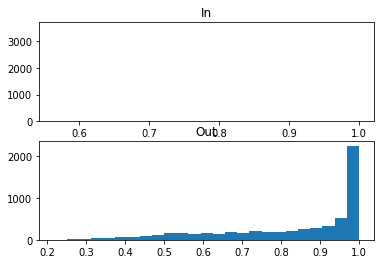

In [23]:
#attack net trained on nn shadow model on nn target
true_positives, false_positives, false_negatives = eval_attack_net(attack_net_nn, target_net, target_train_loader, target_out_loader, k)

In [24]:
print('TP',true_positives)
print('FP', false_positives)
print('FN', false_negatives)



TP 5978
FP 2013
FN 38


In [25]:
#attack net trained on nn shadow model on svm target, C=10, gamma=.1
# eval_attack_net(attack_net_nn, gen_svm, sv_target_train_loader, sv_target_out_loader, k)

In [36]:
#table with 

#baselines
columns = ['Transform','Training epochs', '# speakers','Train accuracy', 'Test accuracy', 'Attack type', 'Precision','Recall']

# do this for 10 & 100 speakers
# .2 S & 3 S
#sufficient training and over-training

#manual data: 
df = pd.DataFrame(columns = columns)
#Attack 1:
df.loc[len(df)] = ['MFCC',25,69.0,.9994,.9632,1,0.79,0.97]
df.loc[len(df)] = ['MFCC',25,255.0,.9961,.9443,1,0.75,0.98] 
df.loc[len(df)] = ['STFT',25,69.0,0.9989,0.9451,1,0.75,0.99] 
df.loc[len(df)] = ['STFT',25,255.0,0.9958,0.9181,1,0.74,0.95] 

#Attack 3 w/max data: 
df.loc[len(df)] = ['STFT',25,139.0,.9985,.9073,3,.81,.90] 
df.loc[len(df)] = ['STFT',25,511.0,.9900,.8943,3,.84,.87] # train more
df.loc[len(df)] = ['MFCC',25,139.0,.9969,.9136,3,.82,.92] 
df.loc[len(df)] = ['MFCC',25,511.0,.9960,.9321,3,0.83,0.93]


#Attack 3 on Attack1 models:
df.loc[len(df)] = ['MFCC',25,69.0,.9994,.9632,3,0.84,0.95] 
df.loc[len(df)] = ['MFCC',25,255.0,.9961,.9443,3,0.84,0.94] 
df.loc[len(df)] = ['STFT',25,69.0,0.9989,0.9451,3,0.81,0.97] #to do
df.loc[len(df)] = ['STFT',25,255.0,0.9958,0.9181,3,0.81,0.90] #to do

df['Training epochs'] =df['Training epochs'].astype(float)
df['Attack type'] =df['Attack type'].astype(float)

#style table
import seaborn as sns

cg = sns.light_palette("green", as_cmap=True)
cm = sns.light_palette("magenta", as_cmap=True)
bl = sns.light_palette("blue", as_cmap=True)
orr = sns.light_palette("orange", as_cmap=True)
gr = sns.light_palette("gray", as_cmap=True)

# df.style.bar(subset=['Train accuracy', 'Test accuracy'], align='mid', color=['#d65f5f', '#5fba7d'])
s = df.style.\
    background_gradient(cmap=cg,subset=['Train accuracy', 'Test accuracy']).\
    background_gradient(cmap=bl,subset=['Precision', 'Recall']).\
    background_gradient(cmap=orr,subset=['Training epochs']).\
    background_gradient(cmap=gr,subset=['Attack type']).\
    background_gradient(cmap=cm,subset=['# speakers']).\
    format({"Train accuracy": "{:.2%}","Test accuracy": "{:.2%}"}).\
    hide_index().\
    set_properties(**{'font-size': "16pt",'column-size':"24pt",'width': '100px'})

s

Transform,Training epochs,# speakers,Train accuracy,Test accuracy,Attack type,Precision,Recall
MFCC,25,69,99.94%,96.32%,1,0.79,0.97
MFCC,25,255,99.61%,94.43%,1,0.75,0.98
STFT,25,69,99.89%,94.51%,1,0.75,0.99
STFT,25,255,99.58%,91.81%,1,0.74,0.95
STFT,25,139,99.85%,90.73%,3,0.81,0.9
STFT,25,511,99.00%,89.43%,3,0.84,0.87
MFCC,25,139,99.69%,91.36%,3,0.82,0.92
MFCC,25,511,99.60%,93.21%,3,0.83,0.93
MFCC,25,69,99.94%,96.32%,3,0.84,0.95
MFCC,25,255,99.61%,94.43%,3,0.84,0.94
